# Traffic Flow Data Warehouse - Exploratory Data Analysis

This notebook performs exploratory data analysis on the traffic flow data to inform our data warehouse design and transformation strategy. We'll focus on the 9 key tables we've selected for our focused approach:

1. TrafficFlow
2. Accidents
3. CongestionLevels
4. Vehicles
5. RoadConditions
6. WeatherData
7. TrafficLights
8. SpeedViolations
9. RoadClosures

The analysis will help us understand data quality issues, relationships between tables, and inform our transformation strategy.

## Setup and Environment

First, let's import the necessary libraries for our analysis.

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
from pathlib import Path
import sys
import re
import missingno as msno
from scipy import stats

# Set plot styles
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('viridis')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

# Set up the path to find the project root
def setup_path():
    """
    Sets up the Python path to include the project root directory.
    Works in both script and notebook environments.
    """
    try:
        # For running as a script
        current_dir = Path(__file__).resolve().parent
    except NameError:
        # For running in Jupyter notebook
        current_dir = Path().absolute()
    
    # Navigate up to project root
    project_root = current_dir
    while project_root.name != "DWH" and project_root.parent != project_root:
        project_root = project_root.parent
    
    if str(project_root) not in sys.path:
        sys.path.append(str(project_root))
    
    return project_root

# Set up path
setup_path()

PosixPath('/home/saad/Documents/Code/DWH')

## Data Loading

Let's load the Excel file containing our traffic data tables.

In [2]:
# Load the data from Excel file
excel_path = "../data/traffic_flow_data.xlsx"
print(f"Loading data from: {excel_path}")

# List of tables we're focusing on for our data warehouse
target_tables = [
    'TrafficFlow', 'Accidents', 'CongestionLevels', 'Vehicles',
    'RoadConditions', 'WeatherData', 'TrafficLights', 
    'SpeedViolations', 'RoadClosures'
]

# Load all tables into a dictionary
tables = {}
for table in target_tables:
    tables[table] = pd.read_excel(excel_path, sheet_name=table)
    print(f"Loaded {table}: {tables[table].shape[0]} rows, {tables[table].shape[1]} columns")

Loading data from: ../data/traffic_flow_data.xlsx
Loaded TrafficFlow: 150 rows, 4 columns
Loaded Accidents: 100 rows, 5 columns
Loaded CongestionLevels: 100 rows, 4 columns
Loaded Vehicles: 200 rows, 4 columns
Loaded RoadConditions: 100 rows, 5 columns
Loaded WeatherData: 100 rows, 5 columns
Loaded TrafficLights: 100 rows, 4 columns
Loaded SpeedViolations: 100 rows, 5 columns
Loaded RoadClosures: 50 rows, 4 columns


## Define Analysis Functions

Create a utility function to provide a comprehensive summary of each dataframe.

In [3]:
def df_summary(df, name):
    """Generate a comprehensive summary of the dataframe"""
    print(f"\n{'='*50}")
    print(f"DATASET: {name}")
    print(f"{'='*50}")
    
    # Basic info
    print(f"\nShape: {df.shape}")
    print(f"\nColumns: {', '.join(df.columns.tolist())}")
    
    # Data types
    print("\nData Types:")
    print(df.dtypes)
    
    # Missing values
    missing = df.isnull().sum()
    if missing.sum() > 0:
        print("\nMissing Values:")
        print(missing[missing > 0])
        print(f"Total missing values: {missing.sum()}")
        # Visualize missing values if there are any
        plt.figure(figsize=(10, 6))
        msno.matrix(df)
        plt.title(f'Missing Values in {name}')
        plt.tight_layout()
        plt.show()
    else:
        print("\nNo missing values.")
    
    # Numeric summary
    numeric_cols = df.select_dtypes(include=['number']).columns
    if len(numeric_cols) > 0:
        print("\nNumeric Summary:")
        print(df[numeric_cols].describe().T)
        
        # Check for outliers
        print("\nOutlier Detection (Z-score > 3):")
        for col in numeric_cols:
            z_scores = np.abs(stats.zscore(df[col].dropna())) # (x - mean) / std_dev
            outliers = np.where(z_scores > 3)[0] # Outliers are defined as data points more than 3 standard deviations from the mean.
            if len(outliers) > 0:
                print(f"  - {col}: {len(outliers)} outliers ({len(outliers)/len(df[col].dropna())*100:.2f}%)")
    
    # Categorical summary
    categorical_cols = df.select_dtypes(include=['object']).columns
    if len(categorical_cols) > 0:
        print("\nCategorical Summary:")
        for col in categorical_cols:
            unique_vals = df[col].nunique()
            print(f"  - {col}: {unique_vals} unique values")
            if unique_vals < 10:  # Only show distribution for low-cardinality categories
                print(df[col].value_counts())
    
    # Date/time summary
    datetime_cols = df.select_dtypes(include=['datetime64']).columns
    if len(datetime_cols) > 0:
        print("\nDateTime Summary:")
        for col in datetime_cols:
            print(f"  - {col}:")
            print(f"    Range: {df[col].min()} to {df[col].max()}")
            date_range = (df[col].max() - df[col].min()).days
            print(f"    Span: {date_range} days")

## Individual Table Analysis

Let's run a comprehensive analysis on each of our target tables.

In [4]:
# Run summary for each dataset
for name, df in tables.items():
    df_summary(df, name)


DATASET: TrafficFlow

Shape: (150, 4)

Columns: FlowID, Location, VehicleCount, Timestamp

Data Types:
FlowID                   int64
Location                object
VehicleCount             int64
Timestamp       datetime64[ns]
dtype: object

No missing values.

Numeric Summary:
              count    mean         std   min     25%    50%     75%    max
FlowID        150.0   75.50   43.445368   1.0   38.25   75.5  112.75  150.0
VehicleCount  150.0  534.58  274.480407  57.0  302.25  534.0  788.50  992.0

Outlier Detection (Z-score > 3):

Categorical Summary:
  - Location: 150 unique values

DateTime Summary:
  - Timestamp:
    Range: 2025-01-01 02:54:05 to 2025-03-02 16:50:59
    Span: 60 days

DATASET: Accidents

Shape: (100, 5)

Columns: AccidentID, Location, Severity, VehiclesInvolved, ReportedAt

Data Types:
AccidentID                   int64
Location                    object
Severity                    object
VehiclesInvolved             int64
ReportedAt          datetime64[ns]
dt

## Location Dimension Analysis

The Location dimension is critical for our data warehouse. Let's analyze how locations are represented across different tables and identify any standardization issues.

In [14]:
print("\n" + "="*50)
print("LOCATION ANALYSIS")
print("="*50)

# Extract all unique locations
location_dfs = ['TrafficFlow', 'Accidents', 'CongestionLevels', 'TrafficLights', 'RoadClosures', 'RoadConditions']
all_locations = set()
location_counts = {}

for df_name in location_dfs:
    if 'Location' in tables[df_name].columns:
        locations = tables[df_name]['Location'].unique()
        all_locations.update(locations)
        location_counts[df_name] = len(locations)

print(f"Total unique locations across all tables: {len(all_locations)}")
print("Location counts by table:")
for df_name, count in location_counts.items():
    print(f"  - {df_name}: {count} locations")

# Check location overlap
print("\nLocation overlap analysis:")
for i, df1 in enumerate(location_dfs):
    for df2 in location_dfs[i+1:]:
        if 'Location' in tables[df1].columns and 'Location' in tables[df2].columns:
            locations1 = set(tables[df1]['Location'].unique())
            locations2 = set(tables[df2]['Location'].unique())
            overlap = locations1.intersection(locations2)
            print(f"  - {df1} and {df2}: {len(overlap)} shared locations ({len(overlap)/len(locations1.union(locations2)):.1%} overlap)")


LOCATION ANALYSIS
Total unique locations across all tables: 599
Location counts by table:
  - TrafficFlow: 150 locations
  - Accidents: 100 locations
  - CongestionLevels: 100 locations
  - TrafficLights: 100 locations
  - RoadClosures: 50 locations
  - RoadConditions: 100 locations

Location overlap analysis:
  - TrafficFlow and Accidents: 0 shared locations (0.0% overlap)
  - TrafficFlow and CongestionLevels: 0 shared locations (0.0% overlap)
  - TrafficFlow and TrafficLights: 0 shared locations (0.0% overlap)
  - TrafficFlow and RoadClosures: 0 shared locations (0.0% overlap)
  - TrafficFlow and RoadConditions: 1 shared locations (0.4% overlap)
  - Accidents and CongestionLevels: 0 shared locations (0.0% overlap)
  - Accidents and TrafficLights: 0 shared locations (0.0% overlap)
  - Accidents and RoadClosures: 0 shared locations (0.0% overlap)
  - Accidents and RoadConditions: 0 shared locations (0.0% overlap)
  - CongestionLevels and TrafficLights: 0 shared locations (0.0% overlap

## Time Dimension Analysis

Time is a critical dimension in our data warehouse. Let's analyze the timestamp fields across our tables to understand their coverage and patterns.

In [6]:
print("\n" + "="*50)
print("TIME DIMENSION ANALYSIS")
print("="*50)

# Compile all date fields
date_columns = {
    'TrafficFlow': 'Timestamp',
    'Accidents': 'ReportedAt', 
    'CongestionLevels': 'RecordedAt',
    'RoadConditions': 'RecordedAt',
    'TrafficLights': 'LastChanged',
    'SpeedViolations': 'Timestamp',
    'RoadClosures': 'ClosedAt',
    'WeatherData': 'Timestamp'
}

# Analyze time ranges across tables
date_ranges = {}
for table, col in date_columns.items():
    if table in tables and col in tables[table].columns:
        min_date = tables[table][col].min()
        max_date = tables[table][col].max()
        date_ranges[table] = (min_date, max_date, (max_date - min_date).days)

print("Date ranges by table:")
for table, (min_date, max_date, days) in date_ranges.items():
    print(f"  - {table} ({date_columns[table]}): {min_date.date()} to {max_date.date()} ({days} days)")


TIME DIMENSION ANALYSIS
Date ranges by table:
  - TrafficFlow (Timestamp): 2025-01-01 to 2025-03-02 (60 days)
  - Accidents (ReportedAt): 2025-01-02 to 2025-03-03 (60 days)
  - CongestionLevels (RecordedAt): 2025-01-01 to 2025-03-02 (60 days)
  - RoadConditions (RecordedAt): 2025-01-01 to 2025-03-03 (61 days)
  - TrafficLights (LastChanged): 2025-01-01 to 2025-03-02 (60 days)
  - SpeedViolations (Timestamp): 2025-01-02 to 2025-03-03 (59 days)
  - RoadClosures (ClosedAt): 2025-01-01 to 2025-03-03 (60 days)
  - WeatherData (Timestamp): 2025-01-02 to 2025-03-02 (59 days)


### Temporal Distribution Analysis

Let's analyze the distribution of data across hours of the day and days of the week to understand traffic patterns.

/tmp/ipykernel_434455/4258995866.py:27: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_xticklabels(days)


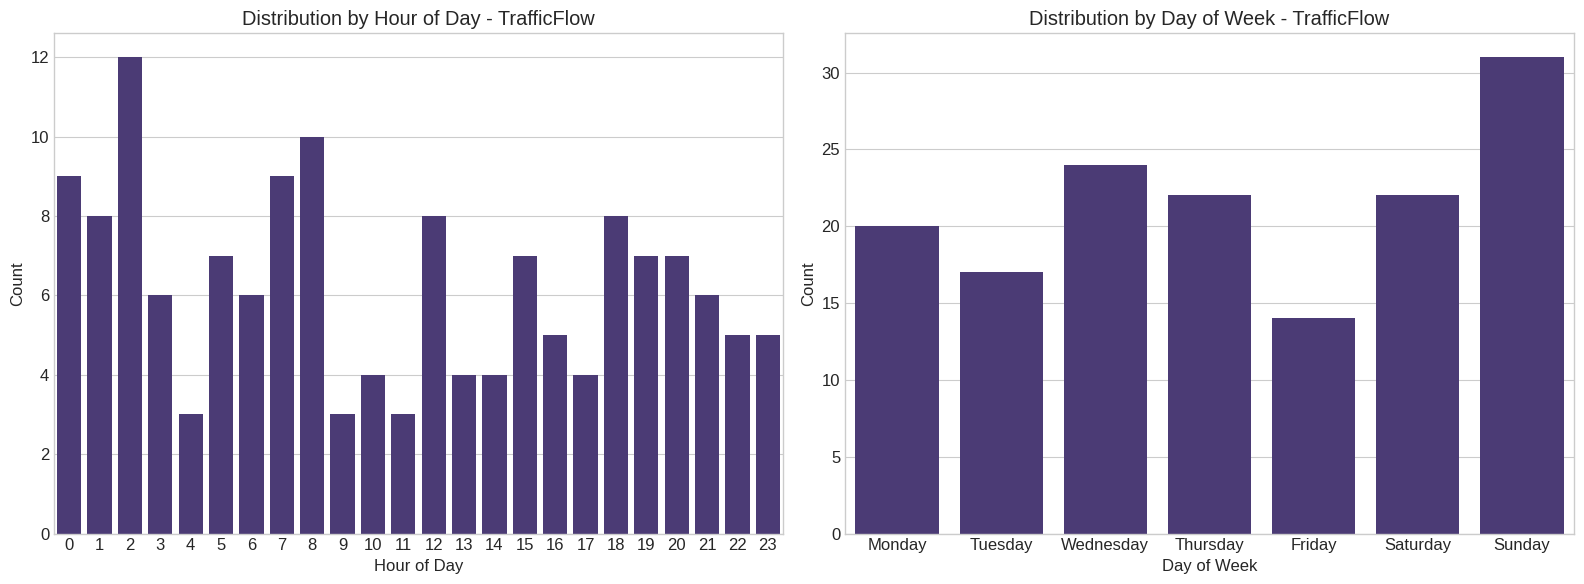

/tmp/ipykernel_434455/4258995866.py:27: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_xticklabels(days)


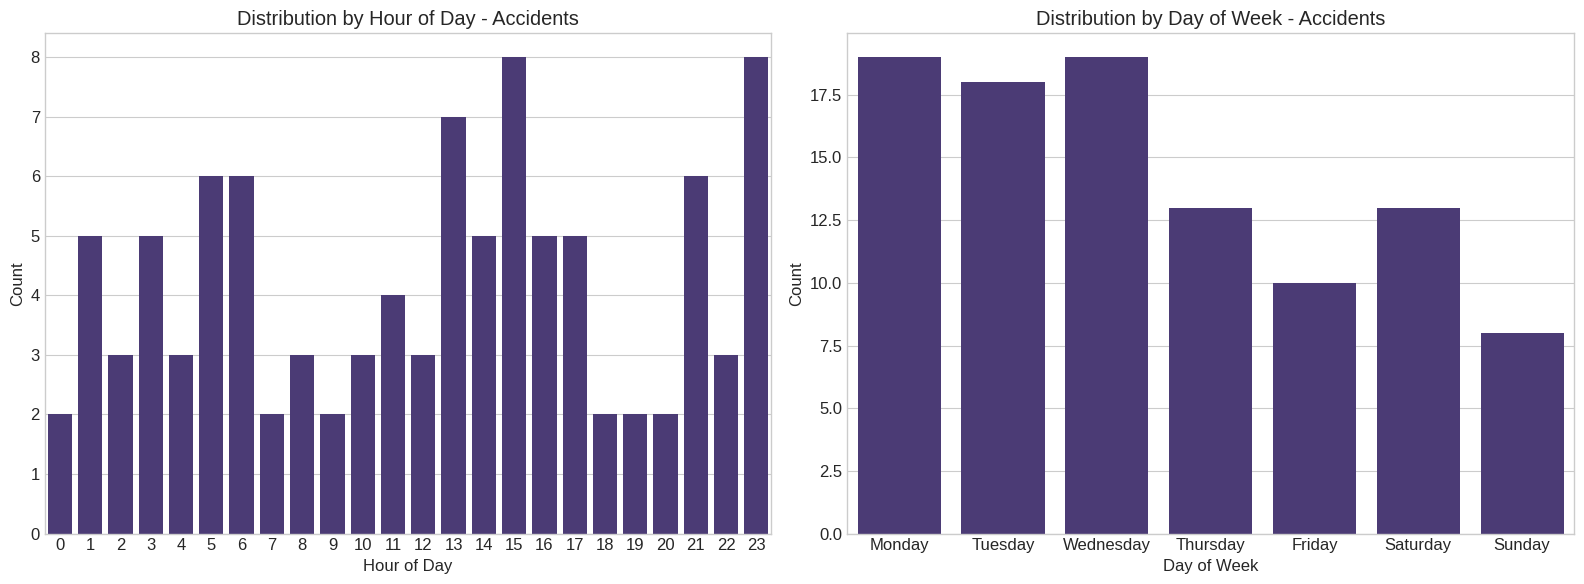

/tmp/ipykernel_434455/4258995866.py:27: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_xticklabels(days)


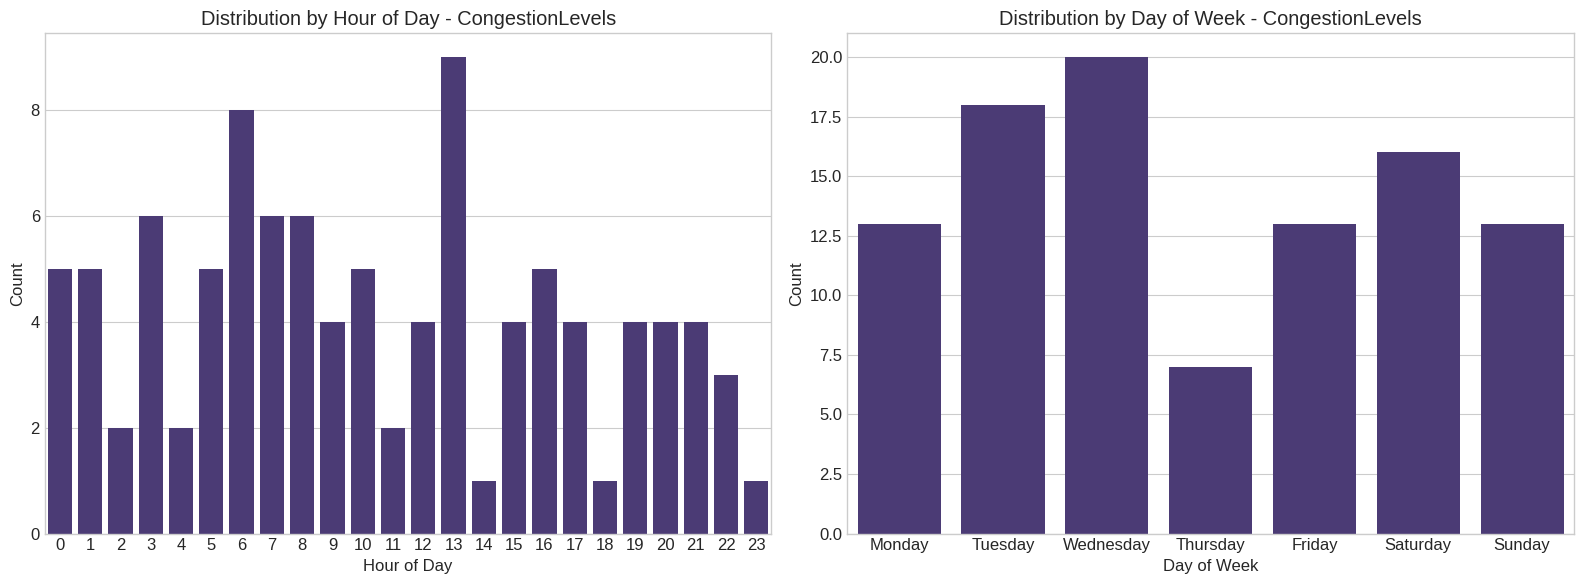

In [7]:
# Focus on key tables with temporal patterns
time_pattern_tables = ['TrafficFlow', 'Accidents', 'CongestionLevels']

for table in time_pattern_tables:
    col = date_columns.get(table)
    if table in tables and col in tables[table].columns:
        # Extract time components
        df = tables[table].copy()
        df['hour'] = df[col].dt.hour
        df['day_of_week'] = df[col].dt.dayofweek
        
        # Create subplots for hour and day of week
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
        
        # Hour of day
        sns.countplot(x='hour', data=df, ax=ax1)
        ax1.set_title(f'Distribution by Hour of Day - {table}')
        ax1.set_xlabel('Hour of Day')
        ax1.set_ylabel('Count')
        
        # Day of week
        days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
        sns.countplot(x='day_of_week', data=df, ax=ax2)
        ax2.set_title(f'Distribution by Day of Week - {table}')
        ax2.set_xlabel('Day of Week')
        ax2.set_ylabel('Count')
        ax2.set_xticklabels(days)
        
        plt.tight_layout()
        plt.show()

## Key Measure Analysis

Let's analyze the key measures that will be used in our fact table.

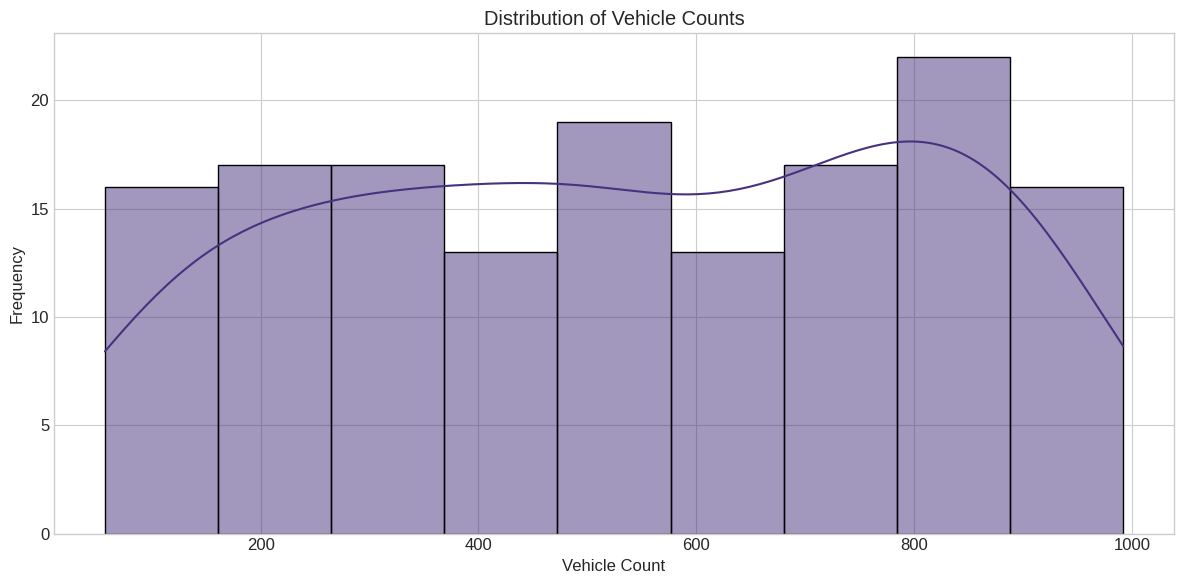

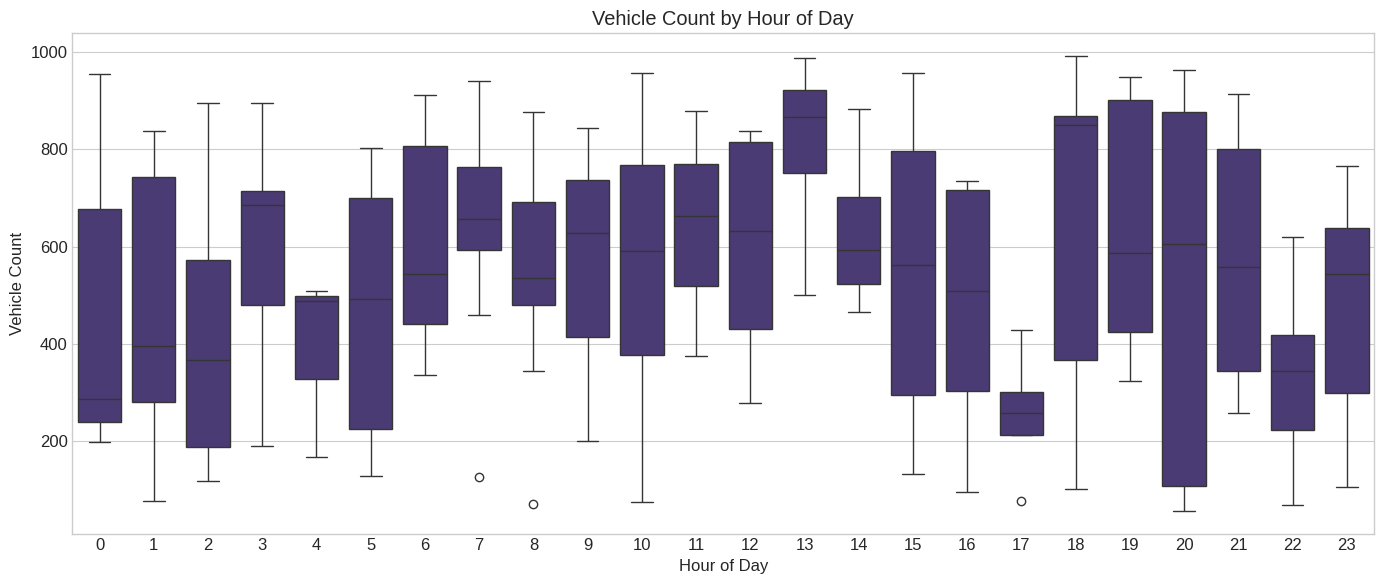

In [8]:
# TrafficFlow - VehicleCount distribution
if 'TrafficFlow' in tables:
    plt.figure(figsize=(12, 6))
    sns.histplot(tables['TrafficFlow']['VehicleCount'], kde=True)
    plt.title('Distribution of Vehicle Counts')
    plt.xlabel('Vehicle Count')
    plt.ylabel('Frequency')
    plt.tight_layout()
    plt.show()
    
    # Add time of day component
    tf = tables['TrafficFlow'].copy()
    tf['hour'] = tf['Timestamp'].dt.hour
    
    plt.figure(figsize=(14, 6))
    sns.boxplot(x='hour', y='VehicleCount', data=tf)
    plt.title('Vehicle Count by Hour of Day')
    plt.xlabel('Hour of Day')
    plt.ylabel('Vehicle Count')
    plt.tight_layout()
    plt.show()

### Accident Analysis

Analyze the accident data to understand severity patterns and their relationship with time.

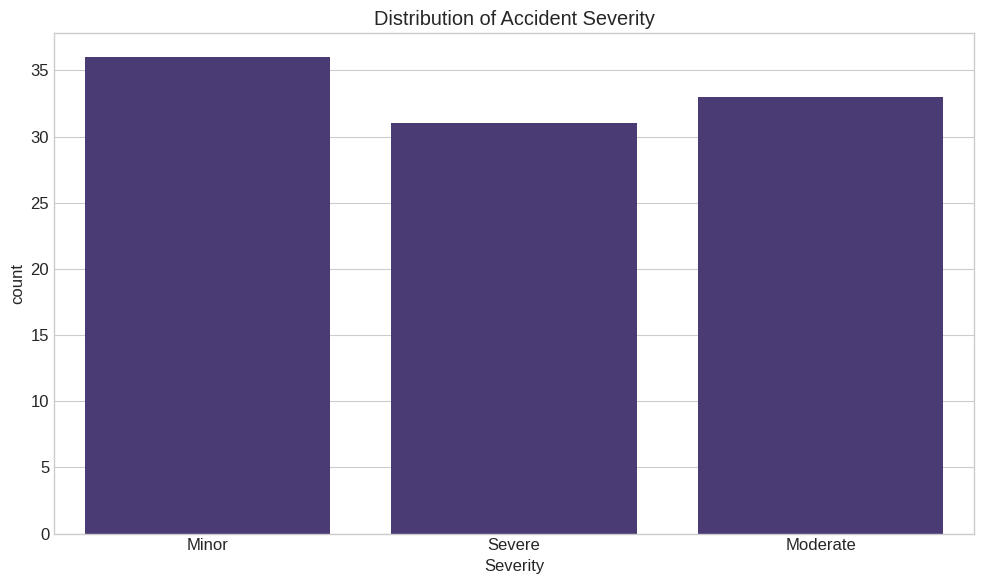

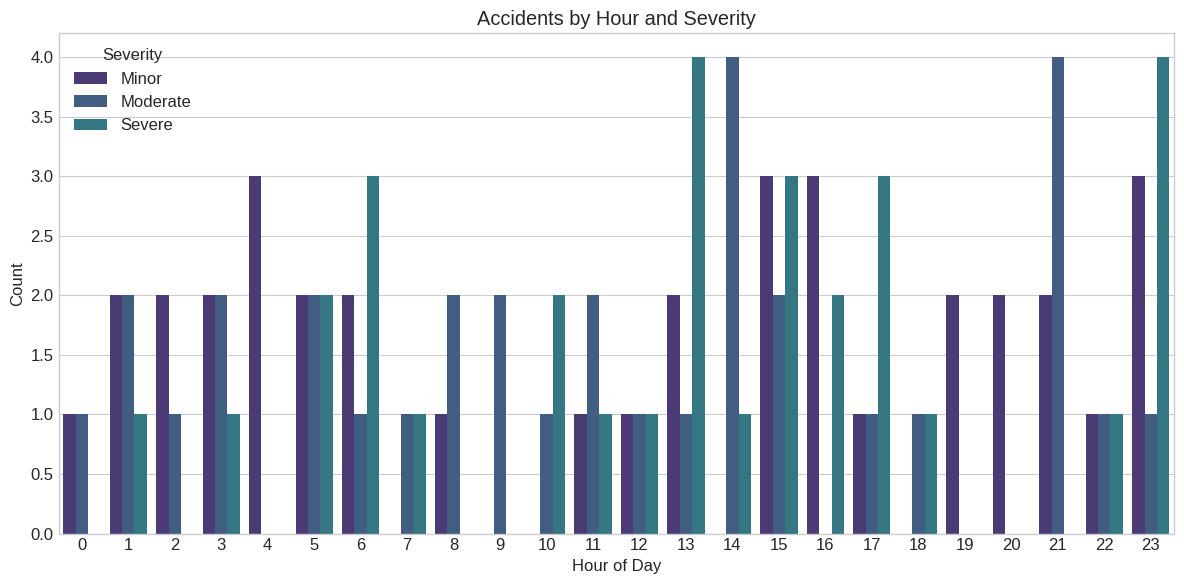

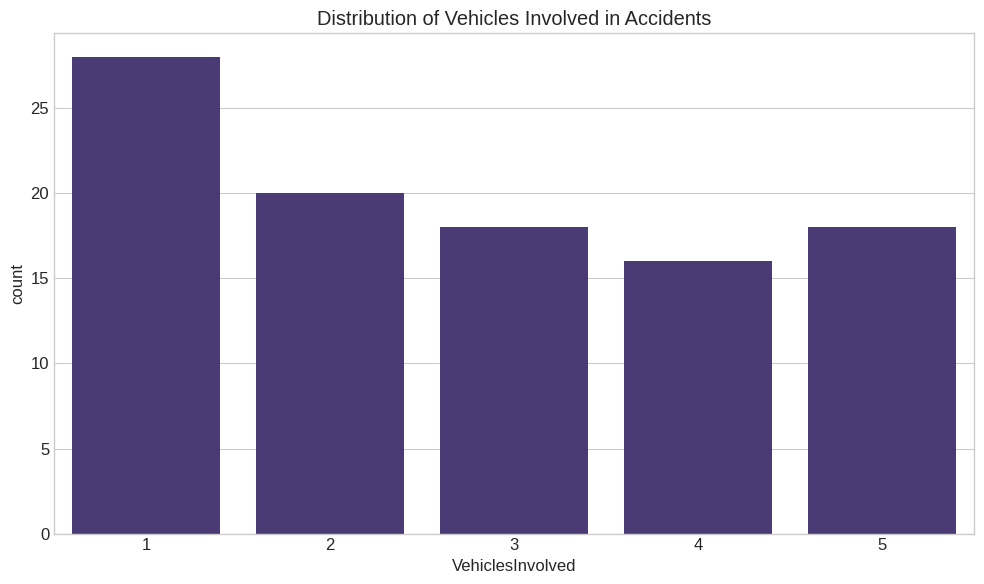

In [9]:
# Analyze accident severity and factors
if 'Accidents' in tables:
    accidents = tables['Accidents'].copy()
    
    # Distribution of accident severity
    plt.figure(figsize=(10, 6))
    sns.countplot(x='Severity', data=accidents)
    plt.title('Distribution of Accident Severity')
    plt.tight_layout()
    plt.show()
    
    # Accidents by hour and severity
    accidents['hour'] = accidents['ReportedAt'].dt.hour
    
    plt.figure(figsize=(12, 6))
    sns.countplot(x='hour', hue='Severity', data=accidents)
    plt.title('Accidents by Hour and Severity')
    plt.xlabel('Hour of Day')
    plt.ylabel('Count')
    plt.tight_layout()
    plt.show()
    
    # Vehicles involved in accidents
    plt.figure(figsize=(10, 6))
    sns.countplot(x='VehiclesInvolved', data=accidents)
    plt.title('Distribution of Vehicles Involved in Accidents')
    plt.tight_layout()
    plt.show()

### Congestion Analysis

Analyze congestion levels to understand patterns and peak times.

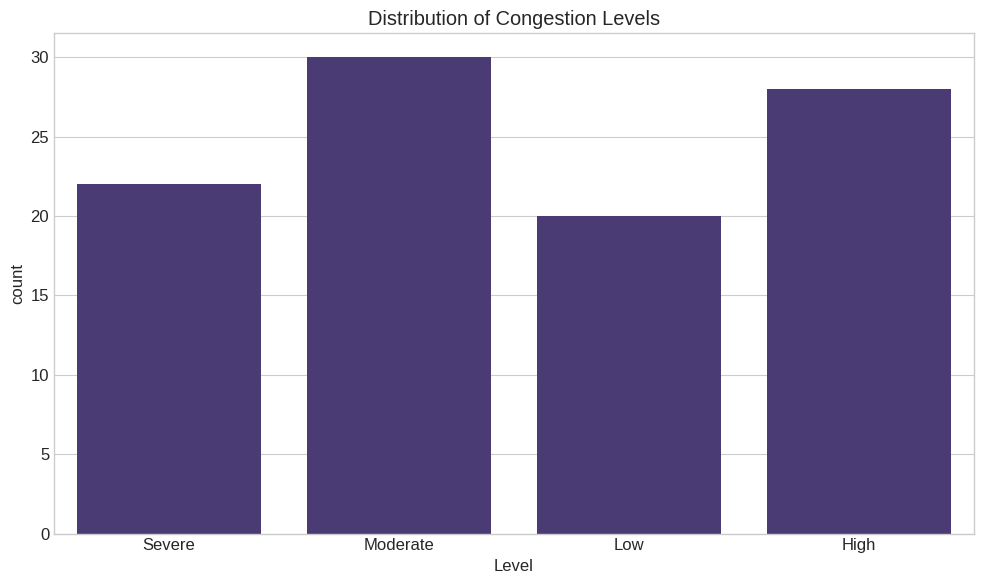

<Figure size 1200x600 with 0 Axes>

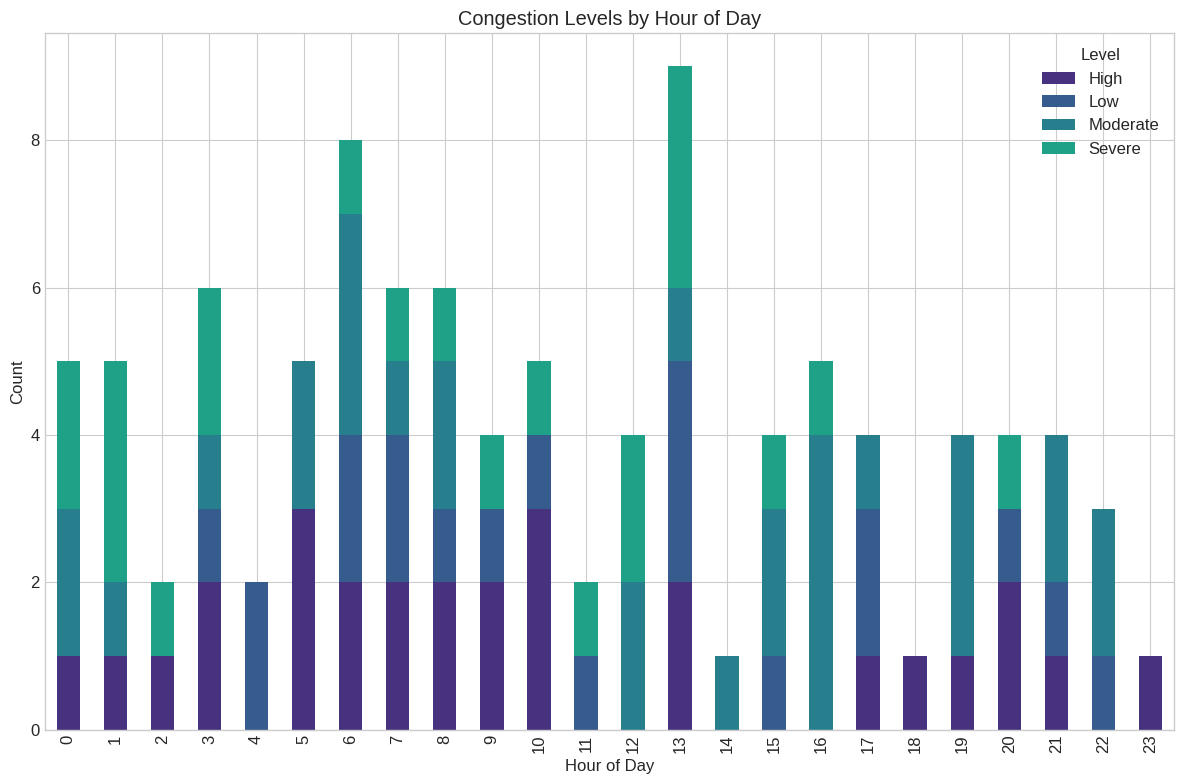

In [10]:
# Analyze congestion patterns 
if 'CongestionLevels' in tables:
    congestion = tables['CongestionLevels'].copy()
    
    # Distribution of congestion levels
    plt.figure(figsize=(10, 6))
    sns.countplot(x='Level', data=congestion)
    plt.title('Distribution of Congestion Levels')
    plt.tight_layout()
    plt.show()
    
    # Congestion by hour of day
    congestion['hour'] = congestion['RecordedAt'].dt.hour
    
    plt.figure(figsize=(12, 6))
    congestion_pivot = congestion.pivot_table(
        index='hour', 
        columns='Level', 
        aggfunc='size', 
        fill_value=0
    )
    congestion_pivot.plot(kind='bar', stacked=True)
    plt.title('Congestion Levels by Hour of Day')
    plt.xlabel('Hour of Day')
    plt.ylabel('Count')
    plt.tight_layout()
    plt.show()

## Cross-Table Relationship Analysis

Let's analyze relationships between different tables to inform our fact table design.

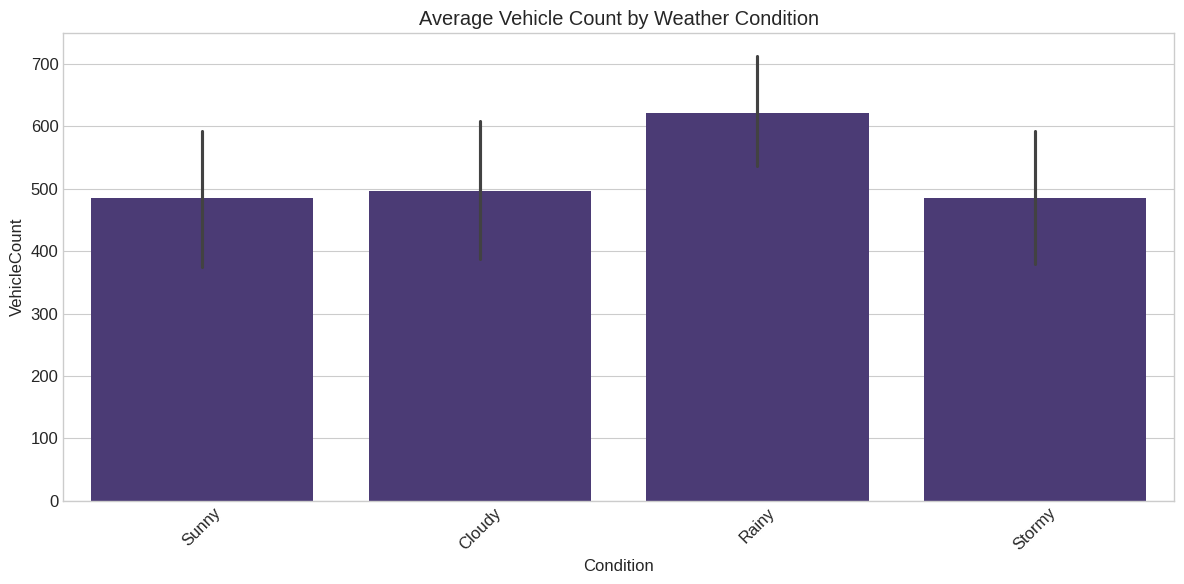

In [11]:
# Analyze traffic flow by environmental conditions
if 'TrafficFlow' in tables and 'WeatherData' in tables:
    # First, we need to join the tables based on nearest timestamp
    tf = tables['TrafficFlow'].copy()
    wd = tables['WeatherData'].copy()
    
    # Simplify by just grouping weather data by date and taking the most common condition
    wd['date'] = wd['Timestamp'].dt.date
    tf['date'] = tf['Timestamp'].dt.date
    
    # Group weather by date and get most common condition
    weather_by_date = wd.groupby('date')['Condition'].agg(lambda x: x.value_counts().index[0]).reset_index()
    
    # Merge with traffic flow
    tf_weather = pd.merge(tf, weather_by_date, on='date', how='left')
    
    # Plot average vehicle count by weather condition
    plt.figure(figsize=(12, 6))
    sns.barplot(x='Condition', y='VehicleCount', data=tf_weather)
    plt.title('Average Vehicle Count by Weather Condition')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

### Vehicle Analysis


Vehicle violation analysis:
  - Total vehicles: 200
  - Vehicles with violations: 78 (39.0%)

Vehicle type distribution:
VehicleType
Truck         32.0%
Motorcycle    24.0%
Bus           22.5%
Car           21.5%
Name: proportion, dtype: object


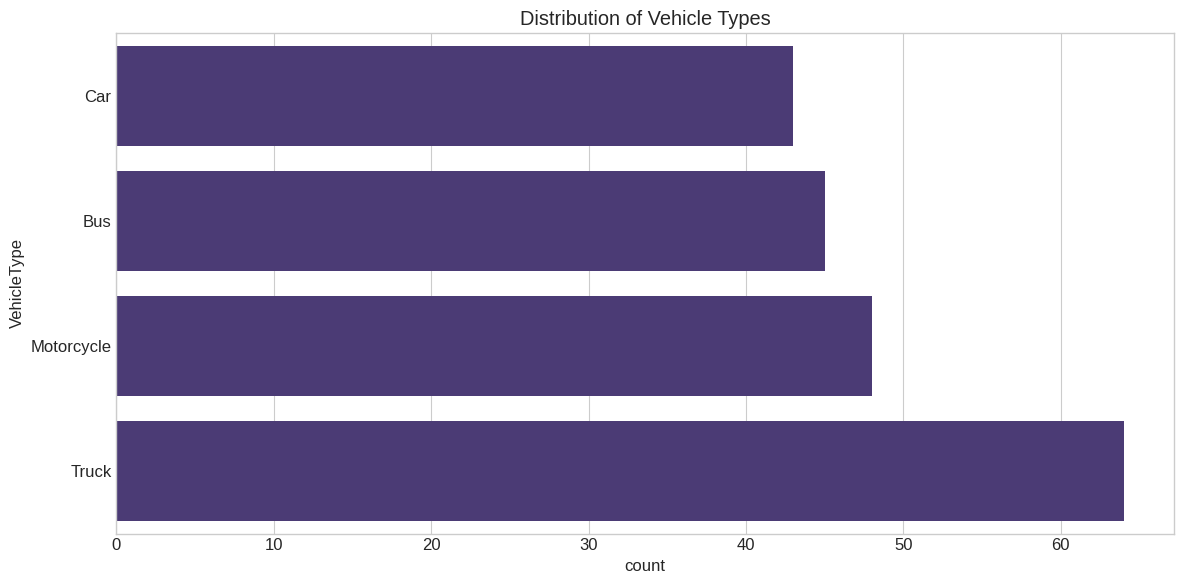


Violating vehicle type distribution:
VehicleType
Truck         33.3%
Motorcycle    23.1%
Car           21.8%
Bus           21.8%
Name: proportion, dtype: object


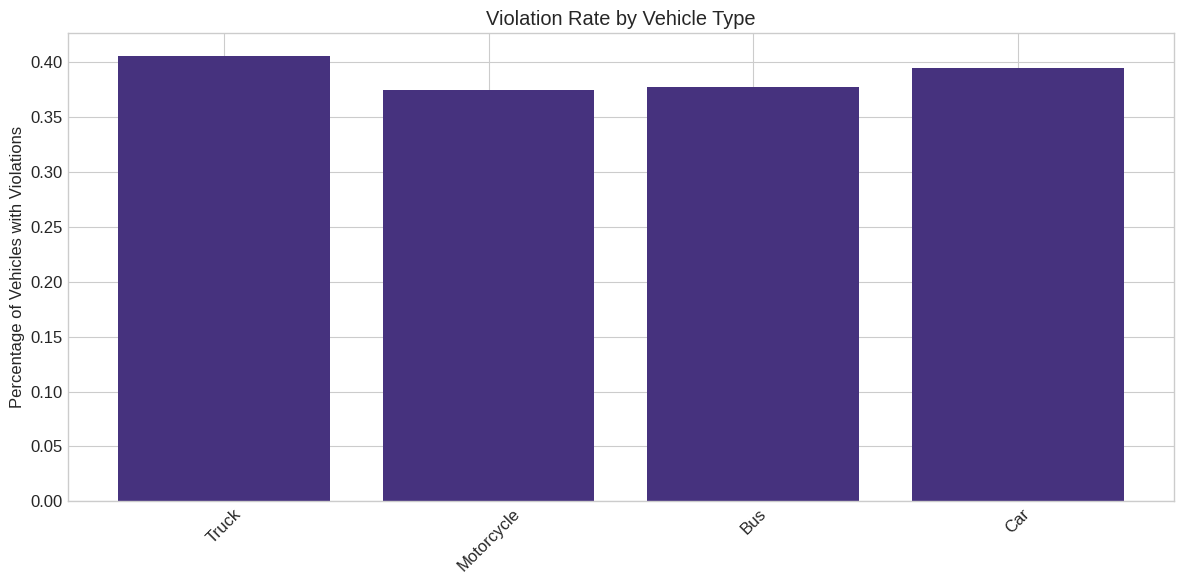

In [12]:
# Vehicle data assessment
if 'Vehicles' in tables and 'SpeedViolations' in tables:
    vehicles = tables['Vehicles']
    violations = tables['SpeedViolations']
    
    # Check which vehicles have violations
    vehicles_with_violations = set(violations['VehicleID'].unique())
    total_vehicles = set(vehicles['VehicleID'].unique())
    
    print(f"\nVehicle violation analysis:")
    print(f"  - Total vehicles: {len(total_vehicles)}")
    print(f"  - Vehicles with violations: {len(vehicles_with_violations)} ({len(vehicles_with_violations)/len(total_vehicles):.1%})")
    
    # Distribution of vehicle types overall
    print("\nVehicle type distribution:")
    print(vehicles['VehicleType'].value_counts(normalize=True).apply(lambda x: f"{x:.1%}"))
    
    # Plot vehicle type distribution
    plt.figure(figsize=(12, 6))
    sns.countplot(y='VehicleType', data=vehicles)
    plt.title('Distribution of Vehicle Types')
    plt.tight_layout()
    plt.show()
    
    # Distribution of vehicle types with violations
    if len(vehicles_with_violations) > 0:
        violating_vehicles = vehicles[vehicles['VehicleID'].isin(vehicles_with_violations)]
        print("\nViolating vehicle type distribution:")
        print(violating_vehicles['VehicleType'].value_counts(normalize=True).apply(lambda x: f"{x:.1%}"))
        
        # Compare violation rates by vehicle type
        plt.figure(figsize=(12, 6))
        vehicle_type_counts = vehicles['VehicleType'].value_counts()
        violating_type_counts = violating_vehicles['VehicleType'].value_counts()
        
        violation_rates = {}
        for vtype in vehicle_type_counts.index:
            if vtype in violating_type_counts:
                violation_rates[vtype] = violating_type_counts[vtype] / vehicle_type_counts[vtype]
            else:
                violation_rates[vtype] = 0
                
        plt.bar(violation_rates.keys(), violation_rates.values())
        plt.title('Violation Rate by Vehicle Type')
        plt.ylabel('Percentage of Vehicles with Violations')
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

## Data Quality Assessment

Let's assess the data quality issues that need to be addressed during transformation.

In [13]:
print("\n\n" + "="*50)
print("DATA QUALITY ASSESSMENT")
print("="*50)

quality_issues = []

# Check for missing values
for name, df in tables.items():
    missing = df.isnull().sum()
    if missing.sum() > 0:
        for col, count in missing[missing > 0].items():
            quality_issues.append(f"Missing values in {name}.{col}: {count} ({count/len(df)*100:.1f}%)")

# Check for duplicate keys
for name, df in tables.items():
    if name + 'ID' in df.columns:
        id_col = name + 'ID'
        dupes = df[df.duplicated(subset=[id_col], keep=False)]
        if len(dupes) > 0:
            quality_issues.append(f"Duplicate IDs in {name}.{id_col}: {len(dupes)} rows")

# Check for referential integrity
if 'SpeedViolations' in tables and 'Vehicles' in tables:
    sv_vehicles = set(tables['SpeedViolations']['VehicleID'].unique())
    vehicles = set(tables['Vehicles']['VehicleID'].unique())
    missing_vehicles = sv_vehicles - vehicles
    if missing_vehicles:
        quality_issues.append(f"Referential integrity issue: {len(missing_vehicles)} VehicleIDs in SpeedViolations not found in Vehicles")

# Check for invalid values
if 'SpeedViolations' in tables:
    sv = tables['SpeedViolations']
    if (sv['SpeedRecorded'] < sv['SpeedLimit']).any():
        invalid_count = (sv['SpeedRecorded'] < sv['SpeedLimit']).sum()
        quality_issues.append(f"Invalid data: {invalid_count} speed violations where recorded speed < speed limit")

# Display quality issues
if quality_issues:
    print("\nIdentified Data Quality Issues:")
    for i, issue in enumerate(quality_issues, 1):
        print(f"{i}. {issue}")
else:
    print("No significant data quality issues identified.")



DATA QUALITY ASSESSMENT

Identified Data Quality Issues:
1. Invalid data: 14 speed violations where recorded speed < speed limit
